# [Sentiment Analysis](https://en.wikipedia.org/wiki/Sentiment_analysis)

_Artificial Intelligence Nanodegree Program | Natural Language Processing by Udacity

---

## Problem

Looking at movie reviews at [imdb](https://www.imdb.com/), classify them into categories of **"positive"** or **"negative"**


## Step 1: Data Understanding

The dataset we are going to use is very popular among researchers in Natural Language Processing, usually referred to as the [IMDb dataset](http://ai.stanford.edu/~amaas/data/sentiment/). It consists of movie reviews from the website [imdb.com](http://www.imdb.com/), each labeled as either '**pos**itive', if the reviewer enjoyed the film, or '**neg**ative' otherwise.

> Maas, Andrew L., et al. [Learning Word Vectors for Sentiment Analysis](http://ai.stanford.edu/~amaas/data/sentiment/). In _Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies_. Association for Computational Linguistics, 2011.


In [2]:
import os
import glob

def read_imdb_data(data_dir='data/imdb-reviews'):
    """Read IMDb movie reviews from given directory.
    
    Directory structure expected:
    - data/
        - train/
            - pos/
            - neg/
        - test/
            - pos/
            - neg/
    
    """

    # Data, labels to be returned in nested dicts matching the dir. structure
    data = {}
    labels = {}

    # Assume 2 sub-directories: train, test
    for data_type in ['train', 'test']:
        data[data_type] = {}
        labels[data_type] = {}

        # Assume 2 sub-directories for sentiment (label): pos, neg
        for sentiment in ['pos', 'neg']:
            data[data_type][sentiment] = []
            labels[data_type][sentiment] = []
            
            # Fetch list of files for this sentiment
            path = os.path.join(data_dir, data_type, sentiment, '*.txt')
            files = glob.glob(path)
            
            # Read reviews data and assign labels
            for f in files:
                with open(f) as review:
                    data[data_type][sentiment].append(review.read())
                    labels[data_type][sentiment].append(sentiment)
            
            assert len(data[data_type][sentiment]) == len(labels[data_type][sentiment]), \
                    "{}/{} data size does not match labels size".format(data_type, sentiment)
    
    # Return data, labels as nested dicts
    return data, labels


data, labels = read_imdb_data()
print("IMDb reviews: train = {} pos / {} neg, test = {} pos / {} neg".format(
        len(data['train']['pos']), len(data['train']['neg']),
        len(data['test']['pos']), len(data['test']['neg'])))

IMDb reviews: train = 12500 pos / 12500 neg, test = 12500 pos / 12500 neg


Now that the data is loaded in, let's take a quick look at one of the positive reviews:

In [3]:
print(data['train']['pos'][2])

A solid, if unremarkable film. Matthau, as Einstein, was wonderful. My favorite part, and the only thing that would make me go out of my way to see this again, was the wonderful scene with the physicists playing badmitton, I loved the sweaters and the conversation while they waited for Robbins to retrieve the birdie.


And one with a negative sentiment:

In [4]:
print(data['train']['neg'][2])

Ouch! This one was a bit painful to sit through. It has a cute and amusing premise, but it all goes to hell from there. Matthew Modine is almost always pedestrian and annoying, and he does not disappoint in this one. Deborah Kara Unger and John Neville turned in surprisingly decent performances. Alan Bates and Jennifer Tilly, among others, played it way over the top. I know that's the way the parts were written, and it's hard to blame actors, when the script and director have them do such schlock. If you're going to have outrageous characters, that's OK, but you gotta have good material to make it work. It didn't here. Run away screaming from this movie if at all possible.


We can also make a wordcloud visualization of the reviews.

In [5]:
# Installing wordcloud
#!pip install wordcloud

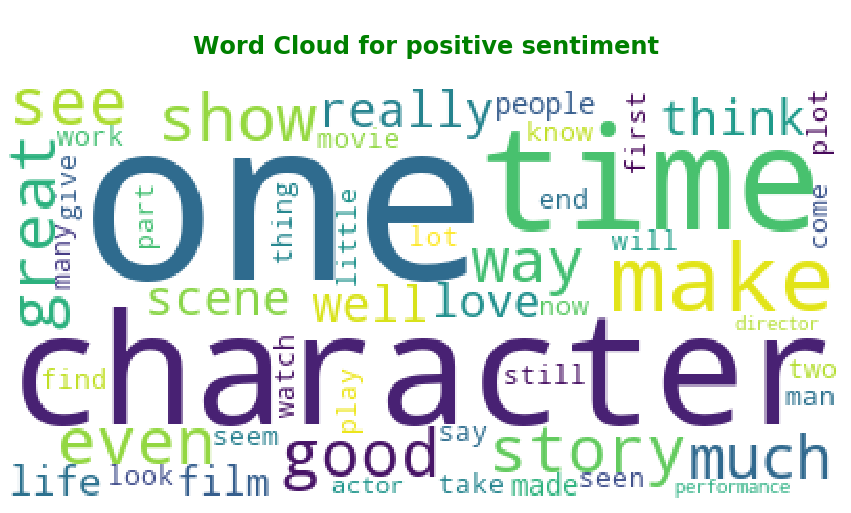

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS

def plotWordCloud(sentiment, titleColor = 'green'):
    # Combine all reviews for the desired sentiment
    combined_text = " ".join([review for review in data['train'][sentiment]])
    # Initialize wordcloud object
    wc = WordCloud(background_color='white', max_words=50,
        # update stopwords to include common words like film and movie
            stopwords = STOPWORDS.update(['br','film','movie']))

    # Generate and plot wordcloud

    fig = plt.figure(figsize=[15,15])
    plt.title('\nWord Cloud for positive sentiment\n', 
                  fontdict = {'fontsize' : 24, 
                              'color' : titleColor,
                              'fontweight' : 'bold'
                             })
    plt.imshow(wc.generate(combined_text))
    plt.axis('off')
    plt.show()

plotWordCloud('pos')

####  changing the sentiment to `'neg'` to  spot any obvious differences between the wordclouds.

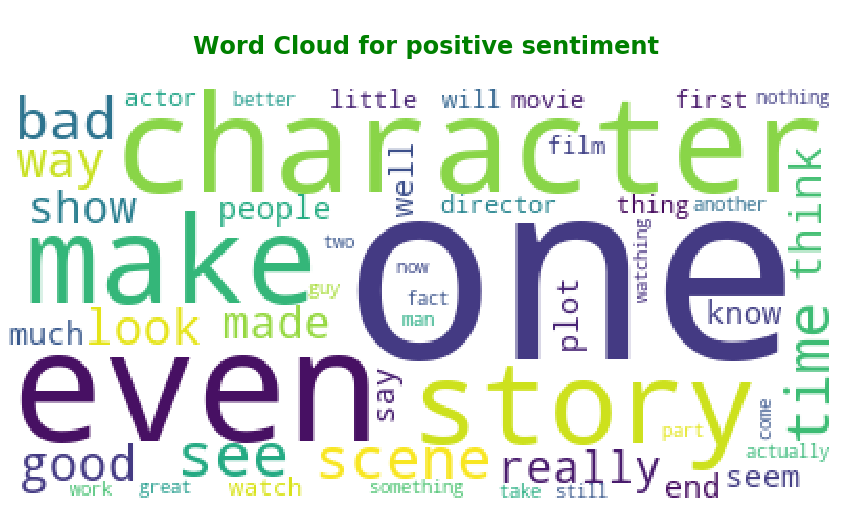

In [7]:
plotWordCloud('neg')

## Data Preparation:
### Form training and test sets

Now that you've seen what the raw data looks like, combine the positive and negative documents to get one unified training set and one unified test set.

In [9]:
from sklearn.utils import shuffle

def prepare_imdb_data(data):
    """Prepare training and test sets from IMDb movie reviews."""
    
    # Combine positive and negative reviews and labels
    data_train = data['train']['pos'] + data['train']['neg']
    data_test = data['test']['pos'] + data['test']['neg']
    labels_train = labels['train']['pos'] + labels['train']['neg']
    labels_test = labels['test']['pos'] + labels['test']['neg']
    
    # Shuffle reviews and corresponding labels within training and test sets
    data_train, labels_train = shuffle(data_train, labels_train)
    data_test, labels_test = shuffle(data_test, labels_test)
    
    # Return a unified training data, test data, training labels, test labets
    return data_train, data_test, labels_train, labels_test


data_train, data_test, labels_train, labels_test = prepare_imdb_data(data)
print("IMDb reviews (combined): train = {}, test = {}".format(len(data_train), len(data_test)))

IMDb reviews (combined): train = 25000, test = 25000


## Data Preparation:

### Preprocessing

Raw data includes HTML. Therefore there are HTML tags that need to be removed. We also need to remove non-letter characters, normalize uppercase letters by converting them to lowercase, tokenize, remove stop words, and stem the remaining words in each document.

###  Convert each review to words

Function `review_to_words()` that performs all these steps. 

In [10]:
# BeautifulSoup to easily remove HTML tags
from bs4 import BeautifulSoup 

# RegEx for removing non-letter characters
import re

# NLTK library for the remaining steps
import nltk
nltk.download("stopwords")   # download list of stopwords (only once; need not run it again)
from nltk.corpus import stopwords # import stopwords

from nltk.stem.porter import *
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /usr/local/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
def review_to_words(review):
    """Convert a raw review string into a sequence of words."""
    
    #       Remove HTML tags and non-letters,
    #       convert to lowercase, tokenize,
    #       remove stopwords and stem html5lib
    text = BeautifulSoup(review,'lxml').get_text()
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    words = text.split()
    words = [w for w in words if w not in stopwords.words("english")]
    words = [PorterStemmer().stem(w) for w in words]
    return words


review_to_words("""This is just a <em>test</em>.<br/><br />
But if it wasn't a test, it would make for a <b>Great</b> movie review!""")

['test', 'test', 'would', 'make', 'great', 'movi', 'review']

With the function `review_to_words()` fully implemeneted, we can apply it to all reviews in both training and test datasets. This may take a while, so let's build in a mechanism to write to a cache file and retrieve from it later.

In [12]:
import pickle

cache_dir = os.path.join("cache", "sentiment_analysis")  # where to store cache files
os.makedirs(cache_dir, exist_ok=True)  # ensure cache directory exists

def preprocess_data(data_train, data_test, labels_train, labels_test,
                    cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
    """Convert each review to words; read from cache if available."""

    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Preprocess training and test data to obtain words for each review
        words_train = list(map(review_to_words, data_train))
        words_test = list(map(review_to_words, data_test))
        
        # Write to cache file for future runs
        if cache_file is not None:
            cache_data = dict(words_train=words_train, words_test=words_test,
                              labels_train=labels_train, labels_test=labels_test)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        words_train, words_test, labels_train, labels_test = (cache_data['words_train'],
                cache_data['words_test'], cache_data['labels_train'], cache_data['labels_test'])
    
    return words_train, words_test, labels_train, labels_test


# Preprocess data
words_train, words_test, labels_train, labels_test = preprocess_data(
        data_train, data_test, labels_train, labels_test)

# Take a look at a sample
print("\n--- Raw review ---")
print(data_train[1])
print("\n--- Preprocessed words ---")
print(words_train[1])
print("\n--- Label ---")
print(labels_train[1])

Wrote preprocessed data to cache file: preprocessed_data.pkl

--- Raw review ---
My 7-year-old daughter loved it, as Disney execs crassly calculated that she would. That's the problem with "Air Buddies." It's a strictly by-the-numbers children's film filled with carefully calculated cuteness, a couple politically correct morals, and enough potty humor to avoid the dreaded G rating. As a parent, or even as a 10-year-old, you've seen it all before, and done better before. Think "101 Dalmatians Meets Home Alone" and you get the general idea. I'm of the opinion that a good children's story is a good story, period. "Air Buddies," which is about as original as recycled paper, fails to meet that standard. It isn't the worst video your child could watch, but there are megatons of better ones.

--- Preprocessed words ---
['7', 'year', 'old', 'daughter', 'love', 'disney', 'exec', 'crassli', 'calcul', 'would', 'problem', 'air', 'buddi', 'strictli', 'number', 'children', 'film', 'fill', 'care', 'c

## Data Preparation :

We will work on extracting the features now.

### Extracting Bag-of-Words features

Now that each document has been preprocessed, we can transform each into a Bag-of-Words feature representation. Note that we need to create this transformation based on the training data alone, as we are not allowed to peek at the testing data at all!

The dictionary or _vocabulary_ $V$ (set of words shared by documents in the training set) used here will be the one on which we train our supervised learning algorithm. Any future test data must be transformed in the same way for us to be able to apply the learned model for prediction. Hence, it is important to store the transformation / vocabulary as well.

> **Note**: The set of words in the training set may not be exactly the same as the test set. What do you do if you encounter a word during testing that you haven't seen before? Unfortunately, we'll have to ignore it, or replace it with a special `<UNK>` token.

### Compute Bag-of-Words features

Implement the `extract_BoW_features()` function, apply it to both training and test datasets, and store the results in `features_train` and `features_test` NumPy arrays, respectively. Choose a reasonable vocabulary size, say $|V| = 5000$, and keep only the top $|V|$ occuring words and discard the rest. This number will also serve as the number of columns in the BoW matrices.

> **Hint**: You may find it useful to take advantage of `CountVectorizer` from scikit-learn. Also make sure to pickle your Bag-of-Words transformation so that you can use it in future.

In [13]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.externals import joblib
# joblib is an enhanced version of pickle that is more efficient for storing NumPy arrays

def extract_BoW_features(words_train, words_test, vocabulary_size=5000,
                         cache_dir=cache_dir, cache_file="bow_features.pkl"):
    """Extract Bag-of-Words for a given set of documents, already preprocessed into words."""
    
    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = joblib.load(f)
            print("Read features from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # TODO: Fit a vectorizer to training documents and use it to transform them
        # NOTE: Training documents have already been preprocessed and tokenized into words;
        #       pass in dummy functions to skip those steps, e.g. preprocessor=lambda x: x
        vectorizer = CountVectorizer(max_features=vocabulary_size,
                preprocessor=lambda x: x, tokenizer=lambda x: x)  # already preprocessed
        features_train = vectorizer.fit_transform(words_train).toarray()

        # TODO: Apply the same vectorizer to transform the test documents (ignore unknown words)
        features_test = vectorizer.transform(words_test).toarray()
        
        # NOTE: Remember to convert the features using .toarray() for a compact representation
        
        # Write to cache file for future runs (store vocabulary as well)
        if cache_file is not None:
            vocabulary = vectorizer.vocabulary_
            cache_data = dict(features_train=features_train, features_test=features_test,
                             vocabulary=vocabulary)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                joblib.dump(cache_data, f)
            print("Wrote features to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        features_train, features_test, vocabulary = (cache_data['features_train'],
                cache_data['features_test'], cache_data['vocabulary'])
    
    # Return both the extracted features as well as the vocabulary
    return features_train, features_test, vocabulary


# Extract Bag of Words features for both training and test datasets
features_train, features_test, vocabulary = extract_BoW_features(words_train, words_test)

# Inspect the vocabulary that was computed
print("Vocabulary: {} words".format(len(vocabulary)))

import random
print("Sample words: {}".format(random.sample(list(vocabulary.keys()), 8)))

# Sample
print("\n--- Preprocessed words ---")
print(words_train[5])
print("\n--- Bag-of-Words features ---")
print(features_train[5])
print("\n--- Label ---")
print(labels_train[5])

/Users/amiteshsinha/Dropbox/Amitesh/Workspace/penv/ml/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Wrote features to cache file: bow_features.pkl
Vocabulary: 5000 words
Sample words: ['rape', 'bottl', 'whole', 'depict', 'difficult', 'behavior', 'spock', 'win']

--- Preprocessed words ---
['bad', 'actor', 'bad', 'film', 'choppi', 'dialog', 'shallow', 'charact', 'bad', 'premis', 'first', 'place', 'basic', '11', 'year', 'old', 'bulli', 'littl', 'money', 'given', 'blank', 'check', 'moron', 'crimin', 'cours', '11', 'year', 'old', 'happen', 'possess', 'enough', 'technolog', 'intellig', 'purchas', 'hous', 'cash', 'check', '1', '000', '000', 'dollar', 'even', 'foil', 'three', 'bumbl', 'idiot', 'reminisc', 'three', 'stoog', 'preston', 'blake', 'annoy', 'obnoxi', 'boy', 'decid', 'written', 'blank', 'check', 'complet', 'stranger', 'take', 'advantag', 'situat', 'best', 'word', 'wander', 'bank', 'hand', 'teller', 'check', 'make', 'printer', 'miracul', 'walk', 'million', 'buck', 'cash', 'preston', 'also', 'appar', 'capabl', 'reach', 'incred', 'speed', 'bicycl', 'due', 'fact', 'man', 'drive', 'jag

Let's try to visualize the Bag-of-Words feature vector for one of our training documents.

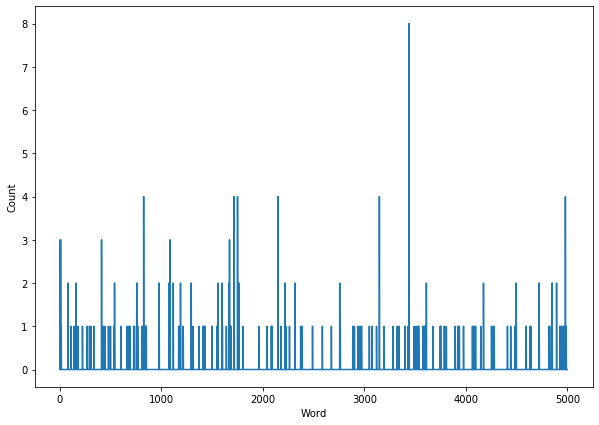

In [16]:
# Plot the BoW feature vector for a training document
plt.figure(figsize=[10,7])
plt.plot(features_train[5,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

### Zipf's law

[Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law), named after the famous American linguist George Zipf, is an empirical law stating that given a large collection of documents, the frequency of any word is inversely proportional to its rank in the frequency table. So the most frequent word will occur about twice as often as the second most frequent word, three times as often as the third most frequent word, and so on. In the figure below we plot number of appearances of each word in our training set against its rank.

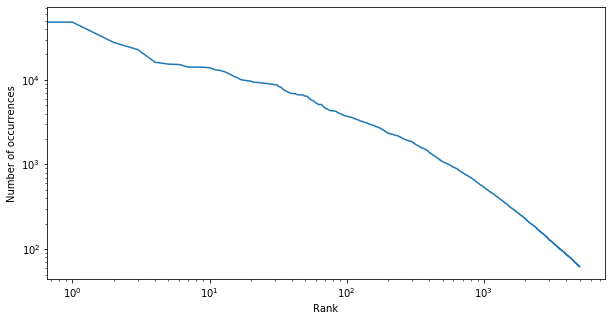

In [18]:
# Find number of occurrences for each word in the training set
word_freq = features_train.sum(axis=0)

# Sort it in descending order
sorted_word_freq = np.sort(word_freq)[::-1]

# Plot 
plt.figure(figsize=[10,5])
plt.plot(sorted_word_freq)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlabel('Rank')
plt.ylabel('Number of occurrences')
plt.show()


### TODO: Normalize feature vectors

Bag-of-Words features are intuitive to understand as they are simply word counts. But counts can vary a lot, and potentially throw off learning algorithms later in the pipeline. So, before we proceed further, let's normalize the BoW feature vectors to have unit length.

This makes sure that each document's representation retains the unique mixture of feature components, but prevents documents with large word counts from dominating those with fewer words.

In [19]:
import sklearn.preprocessing as pr

# TODO: Normalize BoW features in training and test set
features_train = pr.normalize(features_train, axis=1)
features_test = pr.normalize(features_test, axis=1)

## Modeling: Classification using BoW features

### Baseline Model: Gaussian Naive Bayes

Now that the data has all been properly transformed, we can feed it into a classifier. To get a baseline model, we train a Naive Bayes classifier from scikit-learn (specifically, [`GaussianNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)), and evaluate its accuracy on the test set.

In [21]:
from sklearn.naive_bayes import GaussianNB


clf1 = GaussianNB()
clf1.fit(features_train, labels_train)

print("[{}] Accuracy: train = {}, test = {}".format(
        clf1.__class__.__name__,
        clf1.score(features_train, labels_train),
        clf1.score(features_test, labels_test)))

[GaussianNB] Accuracy: train = 0.8198, test = 0.72768


Tree-based algorithms often work quite well on Bag-of-Words as their highly discontinuous and sparse nature is nicely matched by the structure of trees. As your next task, you will try to improve on the Naive Bayes classifier's performance by using scikit-learn's Gradient-Boosted Decision Tree classifer.

### Advanced Model: Gradient-Boosted Decision Tree classifier

Use [`GradientBoostingClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) from scikit-learn to classify the BoW data. This model has a number of parameters. We use default parameters for some of them , We try to tune one hyperparameter : `n_estimators` to classify the data, and report how much improvement you get over Naive Bayes in terms of accuracy.

> **Tip**: Use a model selection technique such as cross-validation, grid-search, or an information criterion method, to find an optimal value for the hyperparameter.

In [23]:
from sklearn.ensemble import GradientBoostingClassifier

n_estimators = 35

def classify_gboost(X_train, X_test, y_train, y_test):        
    # Initialize classifier
    clf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=1.0, max_depth=1, random_state=0)

    # Classify the data using GradientBoostingClassifier
    clf.fit(X_train,y_train)
    
    # To do this later: Perform hyperparameter tuning / model selection
    
    # TODO: Print final training & test accuracy
    print("[{}] Accuracy: train = {}, test = {}".format(
            clf.__class__.__name__,
            clf.score(X_train, y_train),
            clf.score(X_test, y_test)))
    # Return best classifier model
    return clf


clf2 = classify_gboost(features_train, features_test, labels_train, labels_test)

[GradientBoostingClassifier] Accuracy: train = 0.7988, test = 0.79372


In [30]:
x = ['NaiveBayes', 'xgBoost']
y = [clf1.score(features_test, labels_test)*100, 100 * clf2.score(features_test, labels_test)]

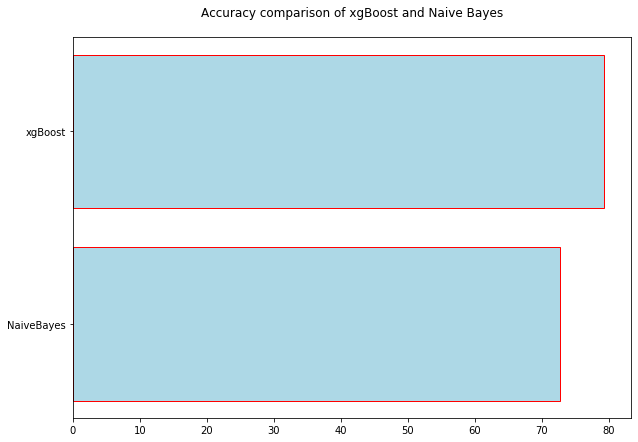

In [46]:
plt.figure(figsize = [10,7])
plt.barh(x,y, color = 'lightblue', edgecolor = 'red')
plt.title('Accuracy comparison of xgBoost and Naive Bayes\n')
plt.show()

### Adverserial testing

We write a short movie review to trick our machine learning model! That is, a movie review with a clear positive or negative sentiment that your model will classify incorrectly.

> **We take advantage of the biggest weakness of the Bag-of-Words scheme!

In [51]:
# Write a sample review and set its true sentiment
my_review = "Without watching, i would have thought it was a terrible movie"
true_sentiment = 'pos'  # sentiment must be 'pos' or 'neg'

# Apply the same preprocessing and vectorizing steps as you did for your training data
expt_words = review_to_words(my_review)
identityFun = lambda x : x
expt_vec = CountVectorizer(vocabulary=vocabulary, preprocessor = identityFun,
                           tokenizer = identityFun)
expt_bow_feature = expt_vec.transform([expt_words]).toarray()
# TODO: Then call your classifier to label it
pred_bow = clf2.predict(expt_bow_feature)

In [53]:
pred_bow[0]

'neg'

## Further Thought

There are several ways in which we can build upon this notebook. Each comes with its set of challenges, but can be a rewarding experience.

- The first thing is to try and improve the accuracy of the model by experimenting with different architectures, layers and parameters. How good can you get without taking prohibitively long to train? How do you prevent overfitting?

- Then, we may want to deploy the model as a mobile app or web service. What do we need to do in order to package the model for such deployment? How would you accept a new review, convert it into a form suitable for your model, and perform the actual prediction? (Note that the same environment you used during training may not be available.)

- One simplification we made in this notebook is to limit the task to binary classification. The dataset actually includes a more fine-grained review rating that is indicated in each review's filename (which is of the form `<[id]_[rating].txt>` where `[id]` is a unique identifier and `[rating]` is on a scale of 1-10; note that neutral reviews > 4 or < 7 have been excluded). How would we modify the notebook to perform regression on the review ratings? In what situations is regression more useful than classification, and vice-versa?
